# | Manhattan City School Analysis |


One of the primary ways an education system can be evaluated is by standardized testing. Within the many tests administered to students, one of the most important is the SAT, or Scholastic Aptitude Test. The test is given to graduating High School students. The SAT is comprised of 3 sections, each of which is worth a maximum of 800 points. A student score on the test is used by Universities in admissions. Adjusting for everything, SAT are typically indicative of more funding and better schools overall. Useful insights can be obtained by analyzing data pertaining to school districts and their students' SAT scores.
   

##### New York City Department of Education has published data on the SAT scores of students, along with additional demographic datasets, and detailed information of K-12 Schools.

- AP test results -- Advanced Placement exam results for each high school.
- Class size -- class size information for each school in NYC.
- Demographics -- demographic information for each school.
- Graduation outcomes -- percentage of students who graduated, and other outcome information.
- SAT scores by school -- SAT scores for each high school in New York City.
- School attendance -- attendance information on every school in NYC.
- School survey -- surveys of parents, teachers, and students at each school.


New York City like many megalopolis' today can be extremely diverse in economic, political, and cultural terms. Analyzing these datasets can give us better insights on the fairness, effectivity, deficiencies, loopholes within the current system.


## I) Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot
import re

from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

## II) Reading the data.
  
We have 7 different dataset Comma Separated values (CSV) files, and two TAB Delimited Value TXT files. These files will all be loaded into Pandas DataFrames, and then for ease of reference, all the Dataframes will be stored into dictionary.
The combined DataFrame will contain all our data and for convenience be stored in a single variable.
 

### Loading NYC School Datasets

In [2]:
files = ["ap_2010.csv", "class_size.csv", "demographics.csv", "graduation.csv", "hs_directory.csv", "math_test_results.csv", "sat_results.csv"]
schoolDF= {}

#load the data
for file in files:
    d = pd.read_csv("./schooldata/{0}".format(file))
    schoolDF[file.replace(".csv", "")] = d
 

### Loading Survey Data
The two text files are tab delimited, and are encoded with Windows-1252 encoding not UFT-8 like CSV's. The most common encodings are UTF-8 and ASCII. We'll need to specify the encoding type (Windows-1252) and delimiter to the pd read_csv function in order to ensure the surveys are read in properly.

In [3]:
survey1 = pd.read_csv("./schooldata/survey_all.txt", delimiter="\t", encoding='windows-1252')
survey2 = pd.read_csv("./schooldata/survey_d75.txt", delimiter="\t", encoding='windows-1252')
schoolSurvey = pd.concat([survey1, survey2], axis=0)

schoolSurvey.head()

C:\Users\jmoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


## III) Overviewing Data

### SAT Data

While all the data sets are important, the main dataset that we are interested in is the SAT_ RESULTS dataset. This contains information about the SAT scores for each high school in New York City and the number of SAT Test Taker. A deep analysis with this dataset and the remaining ones will be elaborated later. We will overview or "explore" this dataset to understand the structure and the information stores within.

In [4]:
schoolDF["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


### Insights after Overviewing the Data
From looking at the data, we can make a few observations:

- The DBN appears to be a unique ID for each school, and it’s a combination of other codes: DBN = "CSD" + "BOROUGH" + "SCHOOL  CODE"
- From looking at the first few rows of names and opening the CSV file in EXCEL we can say that we only have data about high school (logically).
- Inferring on how the DBN code is created, and further looking into the dataset, we can say there is only a single row for each high school, and each DBN is unique in the SAT data.
- Out of columns: SAT Critical Reading Avg., Score SAT Math Avg. Score, and SAT Writing Avg. from the SAT_RESULTS we can make another column to get their full score.

Given these observations, let us explore the other datasets to see if we can get any insight into how to combine the datasets.


In [5]:
#print the data    
for i,j in schoolDF.items():
    print("\n" + i + "\n")
    print(j.head())


ap_2010

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  

class_size

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K

## IV) Data Cleaning
The data must be organized and cleansed before any statistics or deep analyses can be completed. Since our data comes from The New York City School Districts,and taking into consideration the previous observations made it's evident that we can join datasets, eliminate redundancies, and find and fill missing values.  

### Cleaning the Survey data
This data set is very different from the CSV files. 

There are two immediate facts that we can see in the data:

- There are over 2000 columns in the data, almost all of which we will not need. We will need to filter this to remove columns to make it easier to work with. The fewer columns, the easier it is to print out the Dataframe, and to find correlations across the whole Dataframe.
- The survey data has a dbn column that we will want to convert to uppercase (DBN) for consistency with the other datasets.

The survey [dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) is very useful for curating the data.

Survey data corresponds to the opinions of persons in a school’s community. It was created to find out how parents, teachers, and students feel about school safety, academic performance, and more. Based on the dictionary, the selected columns are the following.


In [6]:
#Adding a copy of the "dbn" column to "DBN" 
schoolSurvey["DBN"] = schoolSurvey["dbn"]
schoolSurveyData = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10",
                    "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
schoolSurvey = schoolSurvey.loc[:,schoolSurveyData]
schoolDF["schoolSurvey"] = schoolSurvey
#survey.shape ##View Shape
schoolSurvey.head() ##View survey data 

C:\Users\jmoli\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [7]:
schoolSurvey.shape

(1702, 23)

### Cleaning other DataSets 
#### Modifing "DBN" Column

When we explored all the datasets, we noticed that not every dataset had a DBN column. Specifically, CLASS_SIZE and HS_DIRECTORY do not have the column as we would like. 
However, CLASS_SIZE does not appear to have the column at all. In the case of HS_DIRECTORY we just must rename it. 


#### Adding DBN to Class_Size
From looking at the data, and as stated before the DBN is just a combination of the CSD, BOUROUGH CODE, and SCHOOL CODE columns in CLASS_SIZE. The main difference is that the DBN is padded so the CSD is always two digits when the number is below 9, we need to add a 0 for the consistency of the data.

We can accomplish this using the Pandas apply method, along with a custom code that:

- Takes in a number.
- Converts the number to a string using the str function.
- Check the length of the string using the len function.
    - If the string is two digits long, return the string.
    - If the string is one digit long, add a 0 to the front of the string, then return it.
    - If the string is b, you can do this with return "0" + b.

Once we have the padded CSD, we can use the + operator to combine the values in the CSD and SCHOOL CODE columns.


In [8]:
def paddedCSD(num):
    fstring = str(num)
    if len(fstring) > 1:
        return fstring
    else:
        return "0" + fstring
    
schoolDF["class_size"]["padded_csd"] = schoolDF["class_size"]["CSD"].apply(paddedCSD)
schoolDF["class_size"]["DBN"] = schoolDF["class_size"]["padded_csd"] + schoolDF["class_size"]["SCHOOL CODE"]

In [9]:
schoolDF["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


#### Adding DBN TO HighSchool Directory.

In [10]:
schoolDF["hs_directory"]["DBN"] = schoolDF["hs_directory"]["dbn"]

### Combining The SAT Scores

For our analysis we will create a new SAT_RESULTS column for the total average SAT score per school, this will facilitate our mathematical analysis condensing thyree columns into one.

The three columns: "SAT Math Avg. Score", "SAT Critical Reading Avg. Score," and "SAT Writing Avg" that we want to join are strings (object-string dataType) so we first have to convert them to numerical dataType, then we will be able to add them.

We can use the .to_numeric function to do this conversion. To avoid errors we pass the keyword argument ' errors="coerce" ' when we call to_numeric, so that any invalid strings that can't be converted to numbers are instead treated as missing values.

In [11]:
satData = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for colData in satData:
    schoolDF["sat_results"][colData] = pd.to_numeric(schoolDF["sat_results"][colData], errors="coerce")

schoolDF['sat_results']['sat_score'] = schoolDF['sat_results'][satData[0]] + schoolDF['sat_results'][satData[1]] + schoolDF['sat_results'][satData[2]]

schoolDF['sat_results'][satData[2]]
# Print to see if everything went well.
print(schoolDF['sat_results']['sat_score'].head())



0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### Condensing The Data
When combining many dataSets into a new concise dataFrame like we are doing in this project, we must make sure that all the original dataSet themselves are condensed. We must separate only the data that is relevant to our query.

#### Condensing Class Size

In [12]:
class_size = schoolDF["class_size"] # we save on the variale class_size
class_size = class_size[class_size["GRADE "] == "09-12"] # We save onto class size only the rows that have "09-12" (high school)
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]  #We save onto class size only the rows that have "GEN ED" (General Education Courses)

In [13]:
class_size.head(2)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292


### Computing Average Class Sizes
As  we can see in the Class_Size dataSet every row corresponds to a class in a particular school, so what will do is group the rows by DBN code (school), and get the mean of those grouping, that way we get the average of all the classes in a school, for our goals, this process doesn't hinder out analysis efforts.

In [14]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
schoolDF["class_size"] = class_size

In [15]:
class_size.head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing Demographics
A similar condensing process as done above is executed. This time we only save the rows that have a '20112012' value in their "schoolyear" column. We select this because it is the most recent data.

In [16]:
schoolDF["demographics"] = schoolDF["demographics"][schoolDF["demographics"]["schoolyear"] == 20112012]

In [17]:
schoolDF["demographics"].head(2)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2


### Condensing Math test results
We select rows in dataSet Math_test_results with "Year" == '2011', again the most recent year of data.

In [18]:
schoolDF["math_test_results"] = schoolDF["math_test_results"][schoolDF["math_test_results"]["Year"] == 2011]
schoolDF["math_test_results"] = schoolDF["math_test_results"][schoolDF["math_test_results"]["Grade"] == '8']

In [19]:
schoolDF["math_test_results"].head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
111,01M034,8,2011,All Students,48,646.0,15.0,31.3,22.0,45.8,11.0,22.9,0.0,0.0,11.0,22.9
280,01M140,8,2011,All Students,61,665.0,1.0,1.6,43.0,70.5,17.0,27.9,0.0,0.0,17.0,27.9
346,01M184,8,2011,All Students,49,727.0,0.0,0.0,0.0,0.0,5.0,10.2,44.0,89.8,49.0,100.0
388,01M188,8,2011,All Students,49,658.0,10.0,20.4,26.0,53.1,10.0,20.4,3.0,6.1,13.0,26.5
411,01M292,8,2011,All Students,49,650.0,15.0,30.6,25.0,51.0,7.0,14.3,2.0,4.1,9.0,18.4


### Condensing Graduation data
In the graduation dataset, two columns interfere with the DBN column, Cohort and Demographic. A Cohort appears to be which year the data was recorded for, and the Demographic appears to be in which group the data was collected. In the same casa as before we select the most recent data: 2006.

In [20]:
schoolDF["graduation"] = schoolDF["graduation"][schoolDF["graduation"]["Cohort"] == "2006"]
schoolDF["graduation"] = schoolDF["graduation"][schoolDF["graduation"]["Demographic"] == "Total Cohort"]

In [21]:
schoolDF["graduation"].head(2)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%


### Converting AP Scores To Numeric
The Advanced Placement, or AP, exams are taken by high school students who want academically challenging classes or who desire to acquire university. We prepare this dataFrame by extraction rows with the 3 main characteristics and saving in new columns.
- AP Test Takers.
- Total Exams Taken.
- Number of Exams with scores greater than 2.

In [22]:
#The first column above, AP Test Takers, has a trailing space at the end.
newColumns = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for column in newColumns:
    schoolDF["ap_2010"][column] = pd.to_numeric(schoolDF["ap_2010"][column], errors="coerce")

In [23]:
schoolDF["ap_2010"].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


## Parsing Coordinates For Each School
We will want to parse the coordinates for each school. This will enable us to map out the schools and figure out any geographic patterns in the data. Currently, the coordinates are in a text field called Location 1 in the hs_directory dataset. We want to extract the latitude and the longitude. Together, the latitude and longitude make up a pair of coordinates and allow us to uniquely locate any place on Earth.

We can do this using a regular expression. We will need to do further processing on this using the split and replace methods on strings to extract each coordinate.


### Extracting The Latitude

In [24]:
def findLat(location):
    coordinates = re.findall("\(.+, .+\)", location)
    latitude = coordinates[0].split(",")[0].replace("(", "")
    return latitude

schoolDF["hs_directory"]["latitude"] = schoolDF["hs_directory"]["Location 1"].apply(findLat)
schoolDF["hs_directory"]["latitude"] = pd.to_numeric(schoolDF["hs_directory"]["latitude"], errors="coerce")

In [25]:
#schoolDF["hs_directory"].head(2)

### Extracting The Longitude
We parsed the latitude from the Location 1 column. Now we'll just need to do the same for the longitude.

In [26]:
def find_lon(location):
    coordinates = re.findall("\(.+, .+\)", location)
    longitude = coordinates[0].split(",")[1].replace(")", "").strip()
    return longitude

schoolDF["hs_directory"]["longitude"] = schoolDF["hs_directory"]["Location 1"].apply(find_lon)
schoolDF["hs_directory"]["longitude"] = pd.to_numeric(schoolDF["hs_directory"]["longitude"], errors="coerce")

In [27]:
#schoolDF["hs_directory"]

### Combining The Datasets

Once we have all our relevant dataSets cleaned and condensed, we can proceed with merging them. Upon merging dataset we can use the pandas .merge() function which supports four types of joins: inner, outer, right, and left. Each of these types of merge dictates how rows are combined.

Since we based the previous condensations on the unique value of DBN of each school, we shall use BDN to match the rows. Nevertheless, it's possible that even though the DBN is unique within each dataset, that there may be DBN values that exist in one dataset but not another. This is because some DBN's may be missing from dataset. The data may be missing for many different reasons ranging from human error to the simple fact that some of the data was acquired at different times. The merging of the data will be executed in two steps, left merges and inner joins.

#### Performing The Left Joins 
Both the ap_2010 and the graduation datasets have many missing DBN values, so we will use a left join when we join the sat_results dataset with them. A left join means that our final Dataframe will have all the same DBN values as the original sat_results Dataframe.

We will need to use the Pandas Left merge method to join Dataframes. The "left" Dataframe is the Dataframe we call the method on, whereas the "right" Dataframe is the one we pass into merge. In this method we "add" rows to SAT_RESULTS from AP_2010 and GRADUATION only when DBN's match. We save the new data onto a new DataFrame.

In [28]:
combinedDF = schoolDF["sat_results"]
combinedDF = combinedDF.merge(schoolDF["ap_2010"], on="DBN", how="left")
combinedDF= combinedDF.merge(schoolDF["graduation"], on="DBN", how="left")

In [29]:
combinedDF.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%


### The Inner Joins
Now that we've done the left joins, we have a new useful dataset, "combinedDF", yet we still have class_size, demographics, survey, and hs_directory left to merge into combinedDf. We use inner-merge because the information on these datasets is more valuable to us.

In [30]:
dataSets = ["class_size", "demographics", "schoolSurvey", "hs_directory"]
for d in dataSets:
    combinedDF = combinedDF.merge(schoolDF[d], on="DBN", how="inner")
    
combinedDF.shape

(363, 159)

In [31]:
combinedDF.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,latitude,longitude
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797


### Filling In Missing Values
Once we have our data merged, we can finalize the cleaning by filling missing data by fillna()/fillnull() method. This method will replace any missing values in a Dataframe with values that we specify. in this case we will fill in missing data with the mean for that column.

In [32]:
combinedDF = combinedDF.fillna(combinedDF.mean())
combinedDF = combinedDF.fillna(0)
#combinedDF.shape

In [33]:
combinedDF.head(2)
#combinedDF.shape

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,latitude,longitude
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797


#### Adding A School District Column
To finalize our Data Cleaning, we will add one last column. This column will store the NYC school district for each unique DBN. We will use this column heavily in our mapping section.

In [34]:
def firstTwoChars(dbn):
    return dbn[0:2]

combinedDF["school_dist"] = combinedDF["DBN"].apply(firstTwoChars)

combinedDF["school_dist"].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

### Finding Correlations
In this section we obtain Pearson's correlation coefficient (r). If an r value falls between -1 and 1, and tells you if the two columns are positively correlated, not correlated, or negatively correlated.

In [35]:
correlations = combinedDF.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
latitude                          -0.121029
longitude                         -0.132222
Name: sat_score, Length: 67, dtype: float64


## V) Visualizing Data

We proceed to visualize the data so we can further analyze our datasets.

### Plotting Survey Correlations
We see high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This makes some sense, it could be representitive of the work ethic of high-quality individuals that are in schools with funding.

How students and teachers perceived safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, because safty in a neighborhood corresponds to the socioeconomic status of a certain area, as well that unsafe areas make it hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards. This possibly confirms a type of cultural bias or a pseudo-placebo type if an effect on the person who does the test. Or on the other hand con tell us on the level of actual education that one has.


In [36]:
x = [schoolSurveyData]
y = combinedDF.corr()["sat_score"][schoolSurveyData]
x  = ['DBN','rr_s','rr_t','rr_p','N_s','N_t','N_p','saf_p_11','com_p_11','eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11',
      'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']

C:\Users\jmoli\Anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


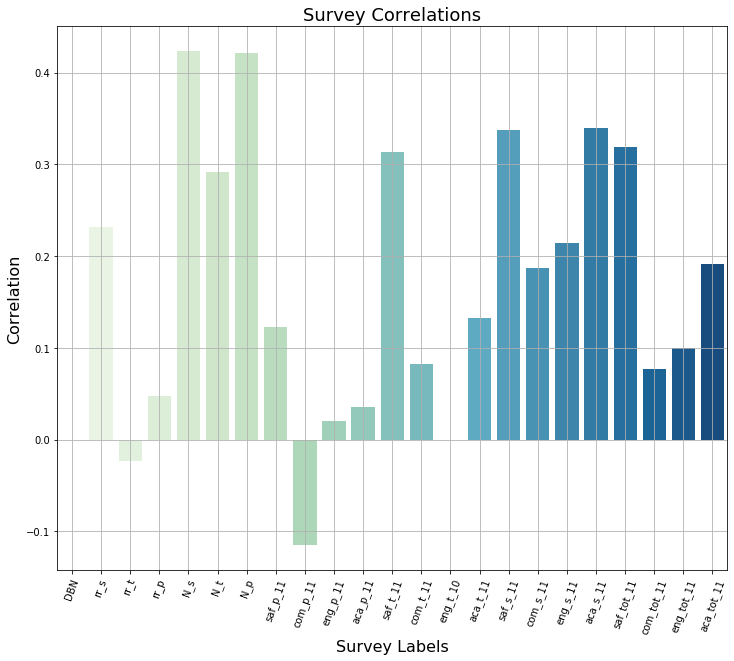

In [37]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(x = x, y = y, palette= "GnBu")
plt.xticks(rotation=70)
plt.ylabel('Correlation', fontsize=16)
plt.xlabel('Survey Labels', fontsize=16)
plt.title('Survey Correlations', fontsize=18)
plt.grid()

### Plotting Enrollment
From the data we can see three main tendencies. 
    1)Low enrollment "specialty school": international, arts, and humanities schools, theses school either do very well or very poor.
    2)Above Average City Schools: from middle income to low high income.
    3)Low income schools with high enrollment: areas with decades of poor public funding, high crime, systemic defecencies, and low expectations.

In [38]:
#combinedDF['total_enrollment']
#combinedDF['sat_score']

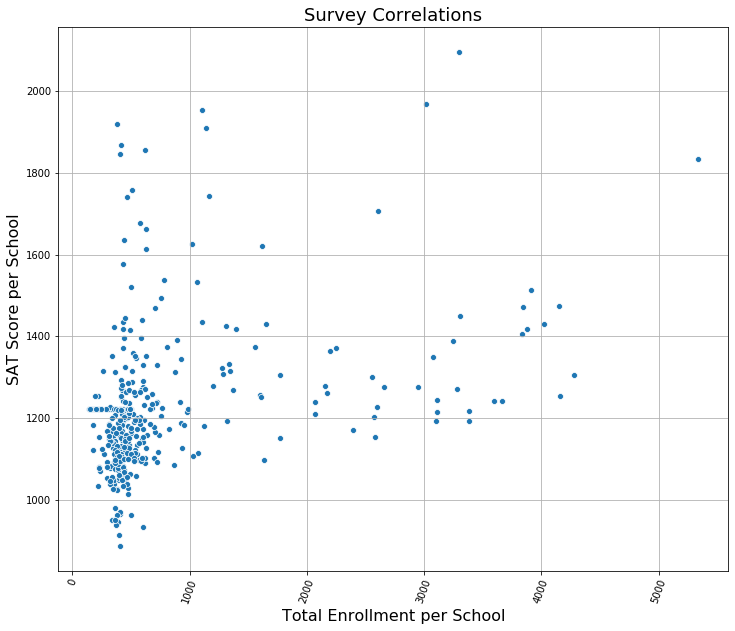

In [39]:
plt.figure(figsize=(12, 10))
a = sns.scatterplot(data=combinedDF, x="total_enrollment", y="sat_score", palette= "Paired")
plt.xticks(rotation=70)
plt.ylabel('SAT Score per School', fontsize=16)
plt.xlabel('Total Enrollment per School', fontsize=16)
plt.title('Survey Correlations', fontsize=18)
plt.grid()

We can also make some other observations:

- total_enrollment correlates strongly positively with sat_score. Schools with low enrollment vary drastically, their students can do very well on the test of very bad. In some privileged STEM school, where the class sizes are small, where students get more attention from the teachers and students typically have better ethics tend to do better on the test. Students from liberal arts, and other types of school do very bad, probably due to the curriculum. Low enrollment low income areas also tend to due horribly as well.
    - Other columns that are proxies for enrollment, like total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS correlate as well.
- The percentage of females at a school (female_per), and the number of females (female_num) correlate positively with SAT score, whereas the percentage of males (male_per), and the number of males (male_num) correlate negatively. This potentially indicates than women do better on the SAT than men, or better: women tend to do better in school in general.
- As to be expected, how highly teachers and students rated safety at the school (saf_t_11, and saf_s_11) correlates with sat_score.
- How highly students rated academic standards (aca_s_11) correlates with sat_score, but this does not hold for teachers and parents (aca_p_11 and aca_t_11), the students do the test not their parents.
- There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of English language learners at the school (ell_percent, frl_percent) correlates strongly negatively with SAT scores, for obvious reasons.

Since enrollment seems to have such a strong correlation in many ways, one of the most is the sample size. Either very large or very small can skew our results.


## Exploring Schools With Low SAT Scores And Enrollment
Enrollment rates and low SAT scores can be explained by two main reasons: socioeconomic status of the area surrounding the school and the sample rates of our data set (mathematical analysis). As explained before there area three main tendencies in the data: privileged-specialty schools, average schools, inner city schools. 
It could be useful to prove one of the obvious points made: low enrollment privileged schools will usually have very bad students or very gifted students, rarely average ones. Cultural bias and low understanding of English in international school can reasonably affect SAT scores. We can extract some of the low enrollment low SAT score:

In [40]:
low_enrollment = combinedDF[combinedDF["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


A person who needs extra English courses in High School that are not part of normal curriculum indicates one or more reasons: low intellectual ability,  privileged poor-dedication (not an area of academic interest), poor environment (socio economic or personal reasons), or someone who speaks English as a second language (cultural bias to an extent). None of these reasons deeply affect average areas of the city (tolerable crime rates, reasonable funding, normal immigration rates, and normal intrapersonal-familial conflicts).

### Plotting Language Learning Percentage
From our research in the last screen, we found that most of the high schools with low total enrollment and low SAT scores are actually schools with a high percentage of English language learners enrolled. This indicates that it's actually ell_percent that correlates strongly with sat_score instead of total_enrollment. To explore this relationship more, let's plot out ell_percent vs sat_score.

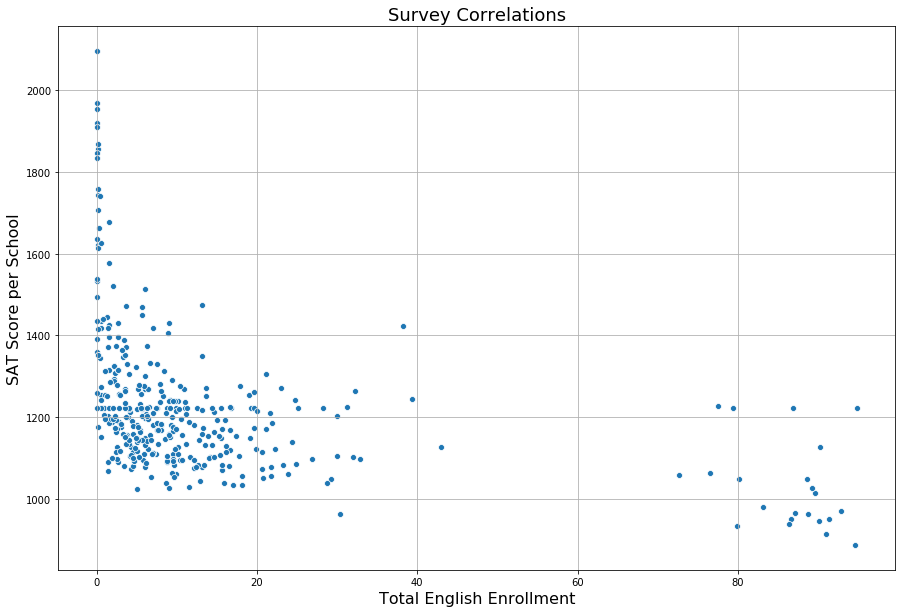

In [41]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=combinedDF, x="ell_percent", y="sat_score")
plt.ylabel('SAT Score per School', fontsize=16)
plt.xlabel('Total English Enrollment', fontsize=16)
plt.title('Survey Correlations', fontsize=18)
plt.grid()

### Mapping The Schools
It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster with very high ell_percent and low sat_score, which is the same group of international high schools that we investigated earlier.

In order to explore this relationship, we'll want to map out ell_percent by school district, so we can more easily see which parts of the city have a lot of English language learners.

In order to do this, we'll need to be able to create maps. We extracted the coordinates of all the schools earlier, and stored them in the lat and lon columns. This will enable us to plot all of the schools onto a map of the US, centered on New York City.

The code above will create a plot, centered on New York City (llcrnrlat, urcrnrlat, llcrnrlon, and urcrnrlon define the corners of the area that's shown), and will draw coastlines and rivers accordingly.

Now, all we need to do is convert our lat and lon coordinates into x and y coordinates so we can plot them on top of the map. This will show us where all the schools in our dataset are located.

In order to plot coordinates using basemap, we need to:

- Convert the Pandas Series containing the latitude and longitude to lists using the tolist method.
- Make a scatterplot using the longitudes and latitudes with the scatter method on the Basemap object.
- Show the plot using the show method.

Additionally, we need to make sure we pass a few keyword arguments to the scatter method:

- s -- this affects the size of the point that represents each school on the map.
- zorder -- this affects where the points that represent schools will be drawn in the z axis. If we set it to 2, the points will be drawn on top of the continents, which is where we want them.
- latlon -- this is a Boolean that specifies whether we're passing in latitude and longitude coordinates instead of x/y plot coordinates.

### Mapping

#### Loading Assets 

In [42]:
# import street map
street_map = gpd.read_file('./geo_export_c0e7a4da-6bf8-42fc-8916-1dd5e4de01b3.shp')

In [43]:
# designate coordinate system
crs = {'init':'espc:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(combinedDF['longitude'], combinedDF['latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(combinedDF, crs = crs, geometry = geometry)
#geo_df.head()

#### Plot Map

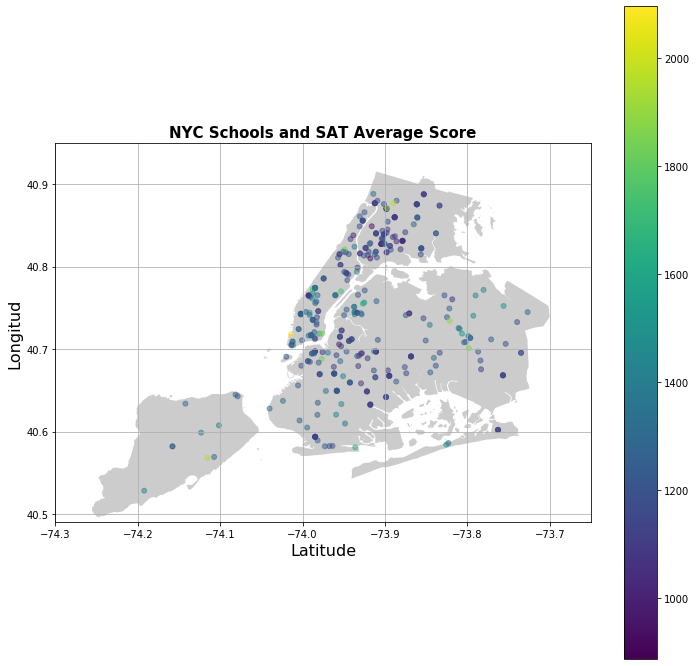

In [44]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(12,12))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='sat_score',ax=ax,alpha=0.5, legend=True,markersize=25)
# add title to graph
plt.title('NYC Schools and SAT Average Score', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-74.3, -73.65)
plt.ylim(40.49, 40.95)
# show map

plt.ylabel('Longitud', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.grid()

### Plotting Out Statistics
From the map above, we can see that schools are the most dense in Manhattan (the top of the map), and less dense in Brooklyn, The Bronx, Queens, and Staten Island.

Now that we can plot out the positions of the schools, we can start to display meaningful information on maps, such as the percentage of English language learners by area.

We can shade each point in the scatterplot by passing the keyword argument c into the scatter method. The c keyword argument will accept a sequence of numbers, and will shade points corresponding to lower numbers or higher numbers differently.

Whatever sequence of numbers we pass into the c keyword argument will be converted to a range from 0 to 1. These values will then be mapped onto a color map. Matplotlib has quite a few default colormaps. In our case, we'll use the summer colormap, which results in green points when the associated number is low, and yellow when it's high.

For example, let's say we plotted ell_percent by school. If we pass in the keyword argument c=combinedDF["ell_percent"], then any school with a high ell_percent would be shaded yellow, and any school with a low ell_percent would be shaded green. We can specify a colormap by passing the cmap keyword argument to the scatter method.

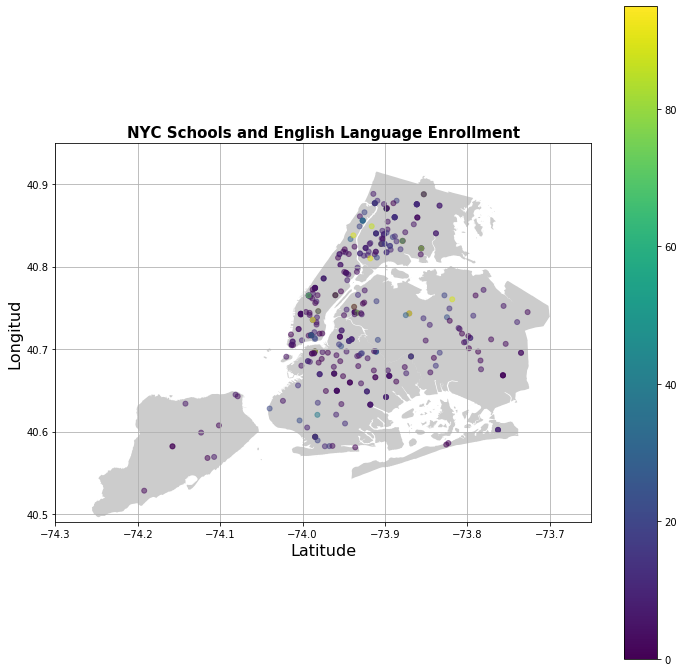

In [45]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(column='ell_percent',ax=ax,alpha=0.5, legend=True,markersize=25)
plt.title('NYC Schools and English Language Enrollment', fontsize=15,fontweight='bold')
plt.xlim(-74.3, -73.65)
plt.ylim(40.49, 40.95)

plt.ylabel('Longitud', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.grid()

### Calculating District Level Statistics

Unfortunately, due to the number of schools, it's hard to interpret the map we made in the last screen. It looks like uptown Manhattan and parts of Queens have a higher ell_percent, but we can't be sure. One way to make it easier to read very granular statistics is to aggregate them. In this case, we can aggregate based on district, which will enable us to plot ell_percent district by district instead of school by school.

In the last mission, we used the groupby and agg methods to find the mean class size for every unique DBN. The principle is the exact same, except here we'd find the mean of each column for every unique value in school_dist.

In [46]:
districts = combinedDF.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,latitude,longitude
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


### Plotting Ell_percent By District
Now that we've taken the mean of all the columns, we can plot out ell_percent by district. Not only did we find the mean of ell_percent, we also took the mean of the lon and lat columns, which will give us the coordinates for the center of each district.

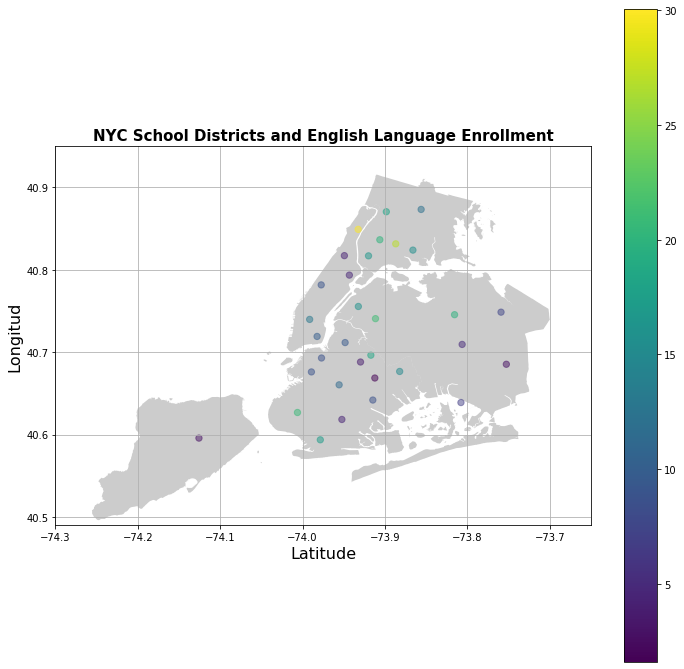

In [47]:
crs = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(districts['longitude'], districts['latitude'])]
geo_dist = gpd.GeoDataFrame(districts, crs = crs, geometry = geometry)
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_dist.plot(column='ell_percent',ax=ax,alpha=0.5, legend=True,markersize=40)
plt.title('NYC School Districts and English Language Enrollment', fontsize=15,fontweight='bold')
plt.xlim(-74.3, -73.65)
plt.ylim(40.49, 40.95)

plt.ylabel('Longitud', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.grid()

### Safety And SAT Scores
We'll investigate safety scores.

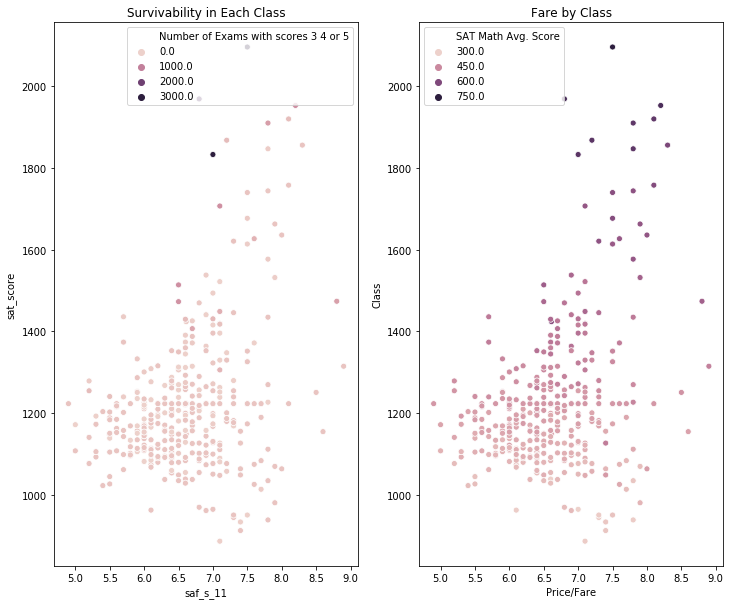

In [48]:
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
plt.figure(figsize=(12, 10))

ax2_1 = plt.subplot(grid[0, 0])
ax2_1 = sns.scatterplot(data=combinedDF, x="saf_s_11", y="sat_score", hue="Number of Exams with scores 3 4 or 5")
plt.title('Survivability in Each Class')

a2_2 = plt.subplot(grid[0, 1:])
a2_2 =sns.scatterplot(data=combinedDF, x="saf_s_11", y="sat_score", hue="SAT Math Avg. Score")
plt.ylabel('Class')
plt.xlabel('Price/Fare')
plt.title('Fare by Class')
plt.legend()

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Plotting safety

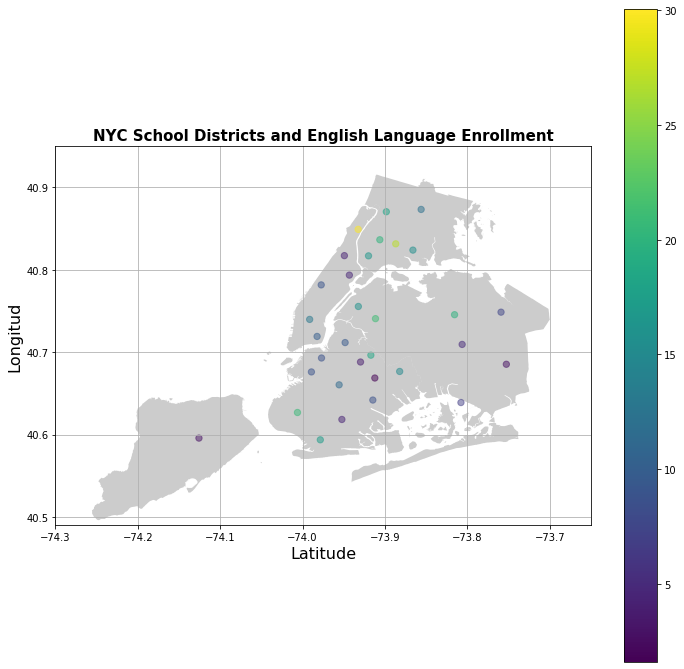

In [49]:
crs = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(districts['longitude'], districts['latitude'])]
geo_dist = gpd.GeoDataFrame(districts, crs = crs, geometry = geometry)

fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_dist.plot(column='ell_percent',ax=ax,alpha=0.5, legend=True,markersize=40)
plt.title('NYC School Districts and English Language Enrollment', fontsize=15,fontweight='bold')
plt.xlim(-74.3, -73.65)
plt.ylim(40.49, 40.95)

plt.ylabel('Longitud', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.grid()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

### Racial differences in SAT scores
There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can see if there are any racial differences in SAT performance.

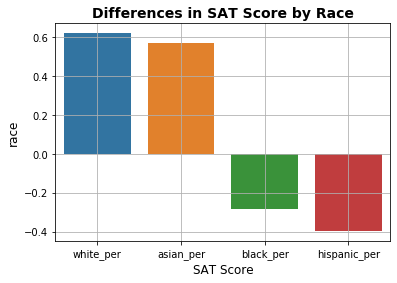

In [50]:
americanRaces = ["white_per", "asian_per", "black_per", "hispanic_per"]
satCorr = combinedDF.corr()["sat_score"][americanRaces]
ax = sns.barplot(x=americanRaces, y=satCorr)

plt.title('Differences in SAT Score by Race', fontsize=14,fontweight='bold')
plt.ylabel('race', fontsize=12)
plt.xlabel('SAT Score', fontsize=12)
plt.grid()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.


Text(0.5, 1.0, 'Balcks in Schools vs SAT Score')

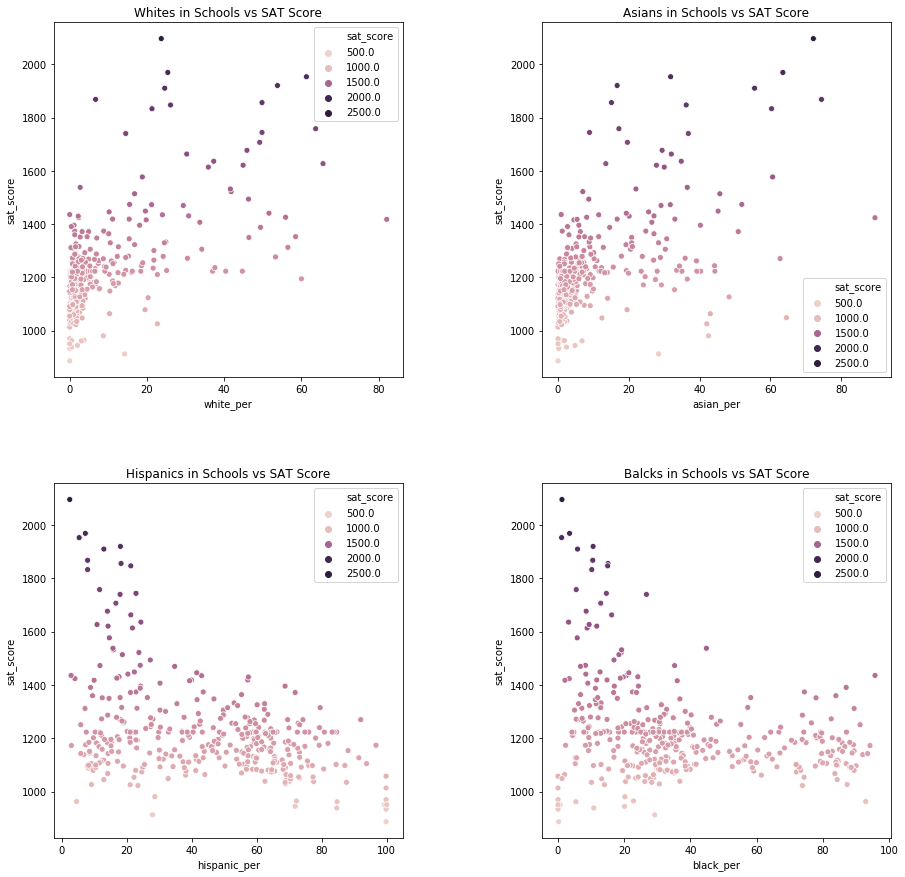

In [51]:
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
plt.figure(figsize=(15, 15))

ax2_1 = plt.subplot(grid[0, 0])
ax2_1 = sns.scatterplot(data=combinedDF, x="white_per", y="sat_score", hue = "sat_score")
plt.title('Survivability in Each Class')
plt.title('Whites in Schools vs SAT Score')


a2_2 = plt.subplot(grid[0, 1:])
a2_2 = sns.scatterplot(data=combinedDF, x="asian_per", y="sat_score", hue = "sat_score")
plt.title('Asians in Schools vs SAT Score')


ax2_3 = plt.subplot(grid[1, 0])
ax2_3 = sns.scatterplot(data=combinedDF, x="hispanic_per", y="sat_score", hue = "sat_score")
plt.title('Hispanics in Schools vs SAT Score')

a2_4 = plt.subplot(grid[1, 1:])
a2_4 = sns.scatterplot(data=combinedDF, x="black_per", y="sat_score", hue = "sat_score")
plt.title('Balcks in Schools vs SAT Score')


In [52]:
print(combinedDF[combinedDF["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [53]:
print(combinedDF[(combinedDF["hispanic_per"] < 10) & (combinedDF["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Gender Differences In SAT Scores

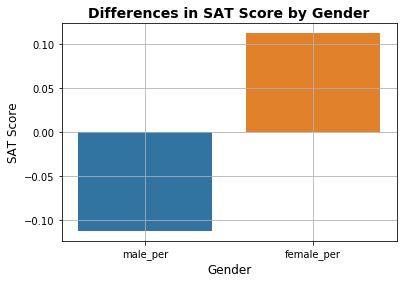

In [54]:
gender = ["male_per", "female_per"]
satCorr = combinedDF.corr()["sat_score"][gender]
sns.barplot(x=gender, y=satCorr)

plt.title('Differences in SAT Score by Gender', fontsize=14,fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('SAT Score', fontsize=12)
plt.grid()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

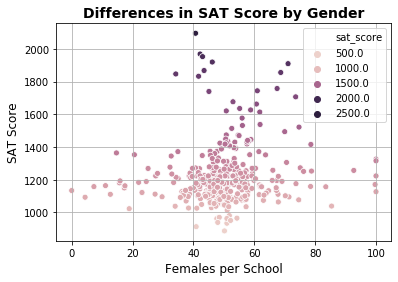

In [55]:
ax = sns.scatterplot(data=combinedDF, x="female_per", y="sat_score", hue = "sat_score")

plt.title('Differences in SAT Score by Gender', fontsize=14,fontweight='bold')
plt.ylabel('SAT Score', fontsize=12)
plt.xlabel('Females per School', fontsize=12)
plt.grid()

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [56]:
print(combinedDF[(combinedDF["female_per"] > 60) & (combinedDF["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

### AP Exam Scores Vs SAT Scores
In the US, the Advanced Placement, or AP, exams, are exams that high schoolers take in order to gain college credit. AP exams can be taken in many different subjects, and passing the AP exam means that colleges may grant you credits.

It makes sense that the number of students who took the AP exam in a school and SAT scores would be highly correlated, and let's dig into the relationship. Since total_enrollment is highly correlated with sat_score, we don't want to bias our results, so we'll instead look at the percentage of students in each school who took at least one AP exam.

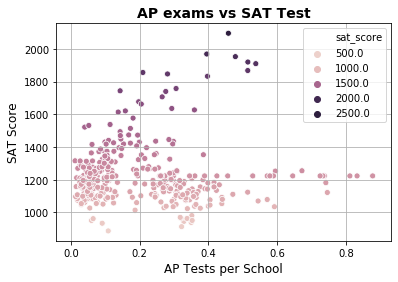

In [57]:
combinedDF["ap_per"] = combinedDF["AP Test Takers "] / combinedDF["total_enrollment"]
sns.scatterplot(data=combinedDF, x="ap_per", y="sat_score", hue = "sat_score")

plt.title('AP exams vs SAT Test', fontsize=14,fontweight='bold')
plt.xlabel('AP Tests per School', fontsize=12)
plt.ylabel('SAT Score', fontsize=12)
plt.grid()

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.